In [5]:
#importing important libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout,Dense,Flatten,Input,Conv2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNet,ResNet50
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

In [6]:
#loading the data
train_data = "C:/Users/megal/Downloads/sanju guvi/training"
test_data = "C:/Users/megal/Downloads/sanju guvi/testing"
val_data = "C:/Users/megal/Downloads/sanju guvi/validation"

In [7]:
#seting Imagedata generator for data argumentation and rescaling
train = ImageDataGenerator(
    rescale = 1./255, #rescale pixel values to [0,1]
    rotation_range = 30, #randomly rotate images
    width_shift_range = 0.2,  #shift image horizontally
    height_shift_range = 0.2,  #shift image vertically
    shear_range = 0.2, #shear image 
    zoom_range = 0.2,  #zooming in or out
    horizontal_flip = True,  #randomaly flip images horizontally
    fill_mode = 'nearest'   #filling any missing pixels after transformations
)

In [8]:
#creating a generator for the training data
train_generators = train.flow_from_directory(
    train_data,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical' 
)

Found 14440 images belonging to 15 classes.


In [9]:
#creating a generator for the testing data
test_generators = train.flow_from_directory(
    test_data,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 3101 images belonging to 15 classes.


In [10]:
#creating a generator for validation data
val_generators = train.flow_from_directory(
    val_data,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 3097 images belonging to 15 classes.


In [13]:
#checking the class label
print(f'Class Label :\n{train_generators.class_indices}')

Class Label :
{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [11]:
#the shape of the image
train_generators.image_shape

(150, 150, 3)

In [12]:
#building cnn model
model = Sequential([
    #convolutional layer + pooling layer
    layers.Conv2D(32,(3,3),activation='relu',input_shape = (150,150,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    #flatten the 3D tensor into 1D
    layers.Flatten(),

    #fully connected (Dense) Layer
    layers.Dense(128,activation = 'relu'),

    #output layer
    layers.Dense(15,activation = 'softmax')
])

In [13]:
#compiling the model
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,830,287 (18.43 MB)

 Trainable params: 4,830,287 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#training the model
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 3,restore_best_weights = True)

#fitting the model
history_cnn = model.fit(
    train_generators,
    epochs = 10,
    validation_data = val_generators,
    verbose = 2
)

Epoch 1/10
452/452 - 226s - 500ms/step - accuracy: 0.6920 - loss: 0.9130 - val_accuracy: 0.7759 - val_loss: 0.6742
Epoch 2/10
452/452 - 292s - 647ms/step - accuracy: 0.7555 - loss: 0.7225 - val_accuracy: 0.8166 - val_loss: 0.5452
Epoch 3/10
452/452 - 275s - 609ms/step - accuracy: 0.8042 - loss: 0.5702 - val_accuracy: 0.8182 - val_loss: 0.5358
Epoch 4/10
452/452 - 271s - 598ms/step - accuracy: 0.8274 - loss: 0.5017 - val_accuracy: 0.8476 - val_loss: 0.4777
Epoch 5/10
452/452 - 269s - 595ms/step - accuracy: 0.8512 - loss: 0.4375 - val_accuracy: 0.8741 - val_loss: 0.3928
Epoch 6/10
452/452 - 268s - 593ms/step - accuracy: 0.8496 - loss: 0.4273 - val_accuracy: 0.8521 - val_loss: 0.4321
Epoch 7/10
452/452 - 266s - 590ms/step - accuracy: 0.8778 - loss: 0.3578 - val_accuracy: 0.8851 - val_loss: 0.3581
Epoch 8/10
452/452 - 268s - 594ms/step - accuracy: 0.8829 - loss: 0.3417 - val_accuracy: 0.8741 - val_loss: 0.3854
Epoch 9/10
452/452 - 269s - 596ms/step - accuracy: 0.8931 - loss: 0.3157 - val_a

Text(0.5, 1.0, 'loss')

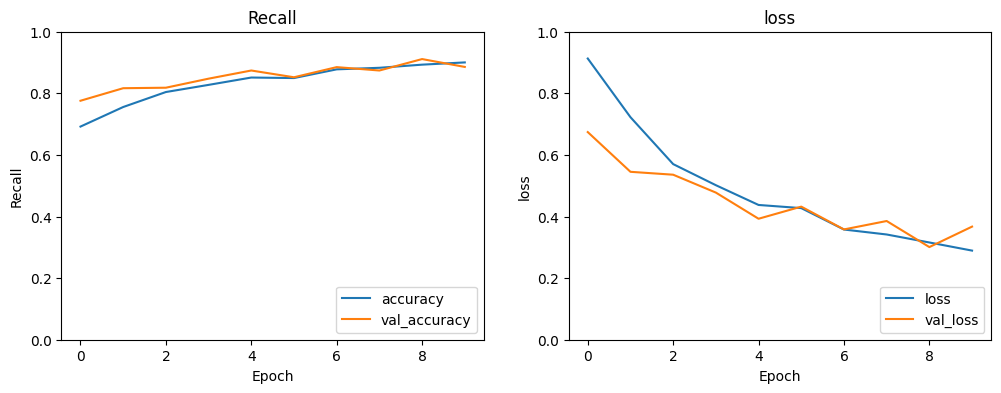

In [16]:
#ploting the training and validation rcall and loss
plt.figure(figsize = (12,4))

#accuracy plot
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'],label = 'accuracy')
plt.plot(history_cnn.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.title('Recall')

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'],label = 'loss')
plt.plot(history_cnn.history['val_loss'],label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.title('loss')


In [17]:
with open('plant_cnn.pkl','wb') as file:
    pkl.dump(model,file)

In [18]:
with open('plant_cnn.pkl','rb') as file:
    cnn = pkl.load(file)

In [19]:
#loading the model
test_loss,test_accuracy = cnn.evaluate(test_generators,verbose = 2)

97/97 - 15s - 158ms/step - accuracy: 0.8817 - loss: 0.3548


In [ ]:
'''
training accuracy as 0.90 and testing accuracy as 0.88 
training loss as 0.289 and testing accuracy as 0.354
The model does not strongly indicate overfitting, as the training and testing accuracies are close, 
and the loss values are not drastically different.
'''

In [38]:
#loading the vgg16 model with neural network and without the last fully connected layers
base_model = VGG16(weights = 'imagenet',include_top = False,input_shape = (150,150,3))

In [39]:
#freeze the base model layers
base_model.trainable = False

In [47]:
#adding custom layers
inputs = Input(shape = (150,150,3))
x = base_model(inputs,training = False)
x = Flatten()(x)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(15,activation = 'softmax')(x)

In [48]:
#model 
model = Model(inputs,outputs)

In [51]:
#compiling the model
model.compile(optimizer = SGD(learning_rate = 0.01),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
)

In [52]:
#fitting the model
history_vgg = model.fit(
    train_generators,
    epochs = 10,
    batch_size = 32,
    validation_data = val_generators
)

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 1447s 3s/step - accuracy: 0.5485 - loss: 1.3597 - val_accuracy: 0.6648 - val_loss: 1.0296
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 1655s 4s/step - accuracy: 0.5772 - loss: 1.2726 - val_accuracy: 0.6642 - val_loss: 1.0133
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 1446s 3s/step - accuracy: 0.5971 - loss: 1.2237 - val_accuracy: 0.6942 - val_loss: 0.9589
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 1616s 4s/step - accuracy: 0.6031 - loss: 1.1678 - val_accuracy: 0.6952 - val_loss: 0.9018
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 1396s 3s/step - accuracy: 0.6218 - loss: 1.1351 - val_accuracy: 0.6913 - val_loss: 0.9200
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 1438s 3s/step - accuracy: 0.6312 - loss: 1.0915 - val_accuracy: 0.6987 - val_loss: 0.8775
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 1364s 3s/step - accuracy: 0.6525 - loss: 1.0477 - val_accuracy: 0.7217 - val_loss: 0.8446
Epoch 8/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 1331s 3s/step - accuracy: 0.6445 - loss: 1.0562 - 

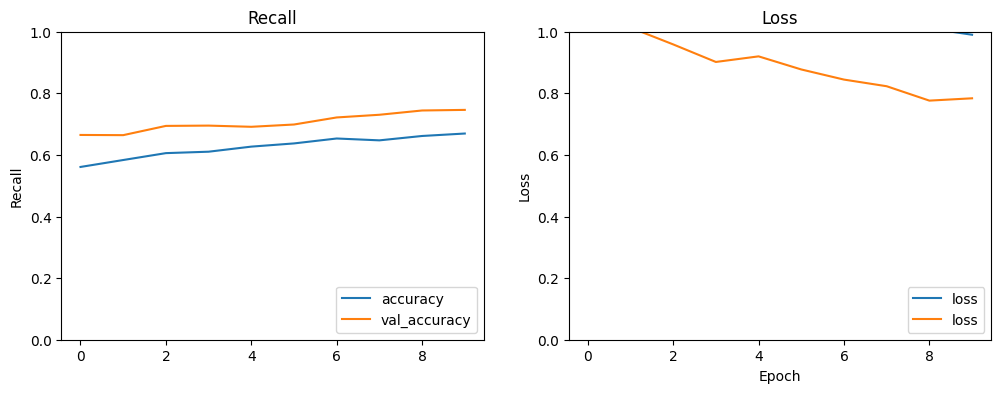

In [56]:
#ploting the training and validation recall and loss
plt.figure(figsize = (12,4))

#accuracy plot
plt.subplot(1,2,1)
plt.plot(history_vgg.history['accuracy'],label = 'accuracy')
plt.plot(history_vgg.history['val_accuracy'],label = 'val_accuracy')
plt.title('Recall')
plt.xlabel
plt.ylabel('Recall')
plt.ylim([0,1])
plt.legend(loc = 'lower right')


plt.subplot(1,2,2)
plt.plot(history_vgg.history['loss'],label = 'loss')
plt.plot(history_vgg.history['val_loss'],label = 'loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.legend(loc = 'lower right')

In [57]:
#saving the model
with open('plant_vgg.pkl','wb') as file:
    pkl.dump(model,file)

In [20]:
#using the model
with open('plant_vgg.pkl','rb') as file:
    vgg = pkl.load(file)

In [21]:
test_loss,test_accuracy = vgg.evaluate(test_generators,verbose = 2)

97/97 - 168s - 2s/step - accuracy: 0.7459 - loss: 0.7916


In [ ]:
'''
training accuracy as  0.6780 and testing accuracy as 0.7459,
training loss as 0.9793 and testing loss as 0.7916
The model shows signs of underfitting, as the training accuracy (0.6780) is significantly 
lower than the testing accuracy (0.7459), and both losses indicate room for improvement.
'''

''

In [55]:
#creating the resnet50 model
resnet_model = Sequential()
resnet = ResNet50(
    include_top = False,
    input_shape = (150,150,3),
    pooling = 'max',
    weights = 'imagenet'
)

In [56]:
#Freezeing the layers of the pretrained model
for layer in resnet.layers:
    layer.trainable = False

resnet_model.add(resnet)


In [57]:
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512,activation = 'relu'))
resnet_model.add(layers.Dense(15,activation = 'softmax'))

#compiling the model
resnet_model.compile(optimizer = Adam(learning_rate = 0.001),loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [58]:
#training the model with early stopping
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 3,restore_best_weights = True)

history_resnet = resnet_model.fit(train_generators,validation_data = val_generators,epochs = 10 )

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.1796 - loss: 2.6014 - val_accuracy: 0.2638 - val_loss: 2.2797
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 598s 1s/step - accuracy: 0.2716 - loss: 2.2161 - val_accuracy: 0.2942 - val_loss: 2.1232
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.3035 - loss: 2.0748 - val_accuracy: 0.3226 - val_loss: 2.0397
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 656s 1s/step - accuracy: 0.3420 - loss: 1.9973 - val_accuracy: 0.3474 - val_loss: 1.9685
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 591s 1s/step - accuracy: 0.3555 - loss: 1.9638 - val_accuracy: 0.3668 - val_loss: 1.9190
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - accuracy: 0.3735 - loss: 1.8853 - val_accuracy: 0.3423 - val_loss: 1.9386
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - accuracy: 0.3874 - loss: 1.8590 - val_accuracy: 0.3862 - val_loss: 1.8462
Epoch 8/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.3847 - loss: 1.8406 - val_accu

In [59]:
with open('plant_resnet.pkl','wb') as file:
    pkl.dump(resnet_model,file)

In [60]:
with open('plant_resnet.pkl','rb') as file:
    res = pkl.load(file)

In [61]:
test_loss,test_accuracy = res.evaluate(test_generators,verbose = 2)

97/97 - 132s - 1s/step - accuracy: 0.3883 - loss: 1.7838


In [ ]:
'''
Training accuracy is  0.4034 and testing accuracy is 0.3883
Training loss is  1.7980 and Testing loss is 1.7838
The model is underperforming, as both training accuracy (0.4034) and 
testing accuracy (0.3883) are low, with only a slight difference in loss values.
'''

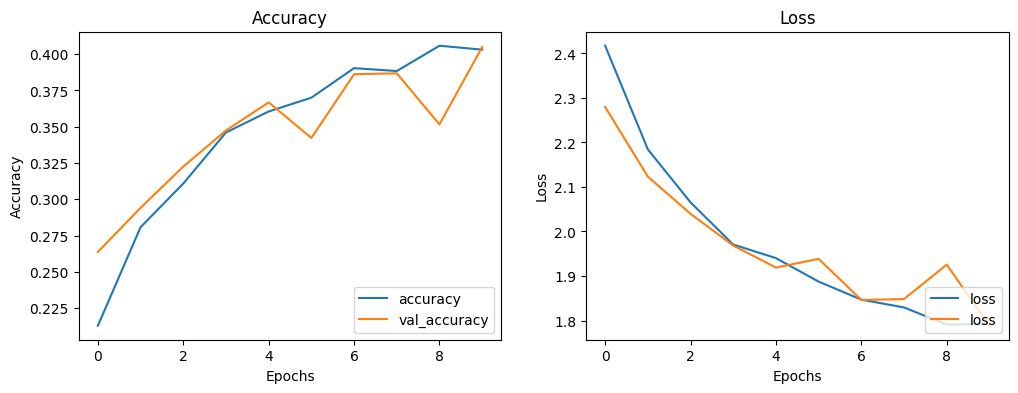

In [64]:
#ploting
plt.figure(figsize = (12,4))

#accuracy
plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'],label = 'accuracy')
plt.plot(history_resnet.history['val_accuracy'],label = 'val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

#loss plot
plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'],label='loss')
plt.plot(history_resnet.history['val_loss'],label = 'loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'lower right')
plt.show()

In [77]:
#mobilenet without top layer
mobile_net = MobileNet(weights = 'imagenet',include_top = False,input_shape = (150,150,3))

#freezing the model
mobile_net.trainable = False

In [78]:
x = mobile_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation = 'relu')(x)
output = Dense(15,activation = 'softmax')(x)

In [79]:
model_mn = Model(inputs = mobile_net.input,outputs = output)

In [80]:
#compiling the  model
model_mn.compile(optimizer = 'Adam',
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

In [81]:
#early stopping
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 3,restore_best_weights = True)

In [82]:
#training the model
history_mn = model_mn.fit(
    train_generators,
    validation_data = val_generators,
    batch_size = 32,
    epochs = 10
)

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 129s 283ms/step - accuracy: 0.6429 - loss: 1.1376 - val_accuracy: 0.8143 - val_loss: 0.5480
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 152s 337ms/step - accuracy: 0.8347 - loss: 0.4862 - val_accuracy: 0.8628 - val_loss: 0.4404
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 157s 347ms/step - accuracy: 0.8616 - loss: 0.3883 - val_accuracy: 0.8605 - val_loss: 0.4094
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 208s 461ms/step - accuracy: 0.8837 - loss: 0.3416 - val_accuracy: 0.8537 - val_loss: 0.4174
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 172s 379ms/step - accuracy: 0.8807 - loss: 0.3339 - val_accuracy: 0.8805 - val_loss: 0.3524
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 163s 360ms/step - accuracy: 0.8916 - loss: 0.3127 - val_accuracy: 0.8928 - val_loss: 0.3280
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 197s 436ms/step - accuracy: 0.9044 - loss: 0.2797 - val_accuracy: 0.8886 - val_loss: 0.3279
Epoch 8/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 200s 443ms/step - accuracy: 0.9046 -

In [83]:
with open('plant_mobile.pkl','wb') as file:
    pkl.dump(model_mn,file)

In [84]:
with open('plant_mobile.pkl','rb') as file:
    mn = pkl.load(file)

In [85]:
test = mn.evaluate(test_generators)

97/97 ━━━━━━━━━━━━━━━━━━━━ 34s 343ms/step - accuracy: 0.8917 - loss: 0.3436


In [ ]:
'''
The model exhibits slight overfitting, as the training accuracy (0.9042) is higher than the testing accuracy (0.8917), 
and the training loss (0.2671) is lower than the testing loss (0.3436).s
'''